<a href="https://colab.research.google.com/github/ac-26/Telecom-Customer-Churn-Prediction/blob/main/quora_question_pairs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

> # Load Dataset

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Quora Question Pairs Dataset.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [44]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404351.000000,404351.000000,404351.000000,404351.000000
mean,202175.000000,391840.987691,390195.973765,0.369248
std,116726.223686,228430.857607,228803.645742,0.482602
min,0.000000,1.000000,2.000000,0.000000
25%,101087.500000,193381.000000,191012.000000,0.000000
50%,202175.000000,390630.000000,388364.000000,0.000000
75%,303262.500000,589514.000000,588071.000000,1.000000
max,404350.000000,789800.000000,789801.000000,1.000000


In [45]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [46]:
df.is_duplicate.value_counts()

,count
is_duplicate,
0,255042
1,149306


<Axes: ylabel='count'>

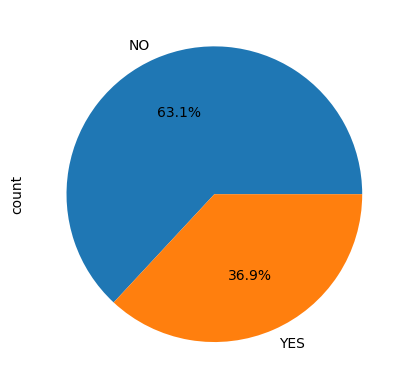

In [47]:
df.is_duplicate.value_counts().plot(kind='pie', labels=['NO', 'YES'], autopct='%1.1f%%')

> # Data Preprocessing

In [48]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

In [49]:
data = df[:10]
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [50]:
data.shape

(10, 6)

In [51]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')


data['question1'] = data['question1'].fillna('').apply(clean_text)
data['question2'] = data['question2'].fillna('').apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-51-ac67ea8de9b8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question1'] = data['question1'].fillna('').apply(clean_text)
<ipython-input-51-ac67ea8de9b8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['question2'] = data['question2'].fillna(

In [52]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


In [53]:
data.question2.values[1]

'would happen indian government stole kohinoor koh noor diamond back'

In [54]:
df.question2.values[1]

'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'

In [55]:
df.question2.values[1]

'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [57]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [58]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [59]:
df = df.sample(frac=0.4, random_state=42).reset_index(drop=True)  # Use only 40% of the dataset

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161739 entries, 0 to 161738
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            161739 non-null  int64 
 1   qid1          161739 non-null  int64 
 2   qid2          161739 non-null  int64 
 3   question1     161739 non-null  object
 4   question2     161739 non-null  object
 5   is_duplicate  161739 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 7.4+ MB


In [61]:
df.is_duplicate.value_counts()

,count
is_duplicate,
0,102234
1,59505


> # Feature Engineering

In [62]:
df['q1_word_count'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_word_count'] = df['question2'].apply(lambda x: len(x.split()))
df['common_word_count'] = df.apply(lambda x: len(set(x['question1'].split()) & set(x['question2'].split())), axis=1)
df['word_share'] = df['common_word_count'] / (df['q1_word_count'] + df['q2_word_count'] + 1e-6)

In [63]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_word_count', 'q2_word_count', 'common_word_count', 'word_share'],
      dtype='object')

In [64]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_word_count,q2_word_count,common_word_count,word_share
0,371032,726051,726052,Do people realize that you can send marijuana ...,How do you send weed through the mail?,0,14,8,3,0.136364
1,263498,518455,518456,How can rock music be brought back?,What would it take for rock music to make a co...,1,7,12,3,0.157895
2,111008,220125,220126,Why does one feel relaxed after smoking a join...,How do I sober up quickly after smoking weed/m...,0,10,13,2,0.086957
3,75665,150351,150352,How to gain weight ?,How do I gain weight fast but still be healthy?,1,5,10,3,0.200000
4,52376,104229,104230,Is porn bad for men?,Can I become a porn fan without getting addicted?,0,5,9,1,0.071429


In [65]:
tfidf = TfidfVectorizer(max_features=5000)
q1_tfidf = tfidf.fit_transform(df['question1'])
q2_tfidf = tfidf.transform(df['question2'])

In [66]:
X = hstack((q1_tfidf, q2_tfidf, df[['q1_word_count', 'q2_word_count', 'common_word_count', 'word_share']].values))
y = df['is_duplicate'].values

> # Visualizations

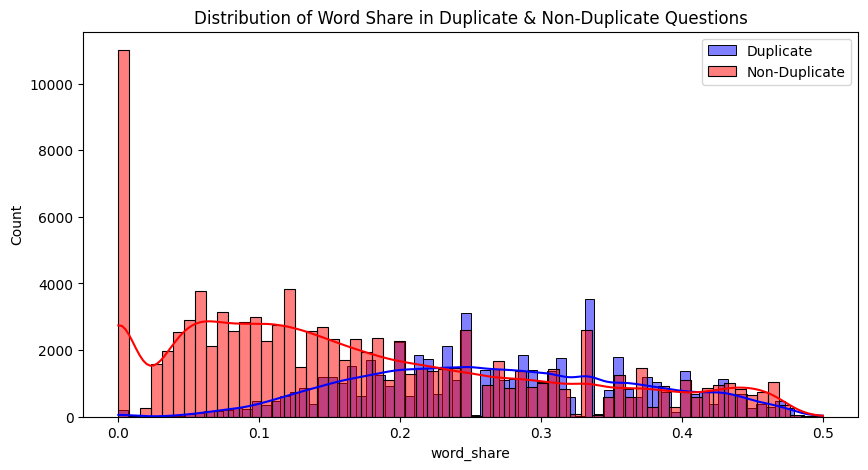

In [67]:
plt.figure(figsize=(10,5))
sns.histplot(df['word_share'][df['is_duplicate'] == 1], color='blue', kde=True, label='Duplicate')
sns.histplot(df['word_share'][df['is_duplicate'] == 0], color='red', kde=True, label='Non-Duplicate')
plt.legend()
plt.title("Distribution of Word Share in Duplicate & Non-Duplicate Questions")
plt.show()

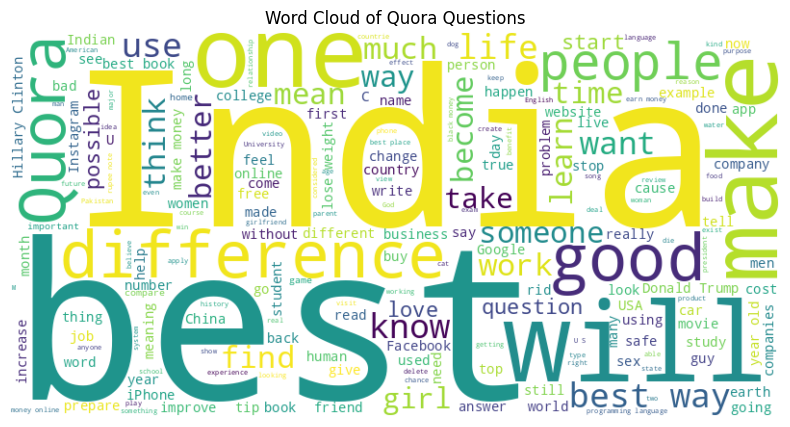

In [68]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['question1'] + " " + df['question2']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Quora Questions")
plt.show()

> # Split Data

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> # Train Models

In [70]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss')
}

In [71]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.7605
              precision    recall  f1-score   support

           0       0.79      0.84      0.82     20346
           1       0.70      0.62      0.66     12002

    accuracy                           0.76     32348
   macro avg       0.75      0.73      0.74     32348
weighted avg       0.76      0.76      0.76     32348

Random Forest Accuracy: 0.7990
              precision    recall  f1-score   support

           0       0.81      0.89      0.85     20346
           1       0.78      0.64      0.70     12002

    accuracy                           0.80     32348
   macro avg       0.79      0.77      0.78     32348
weighted avg       0.80      0.80      0.79     32348



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7747
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     20346
           1       0.70      0.69      0.69     12002

    accuracy                           0.77     32348
   macro avg       0.76      0.76      0.76     32348
weighted avg       0.77      0.77      0.77     32348



> # Compare Models

<ipython-input-72-6a488f63e2f9>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


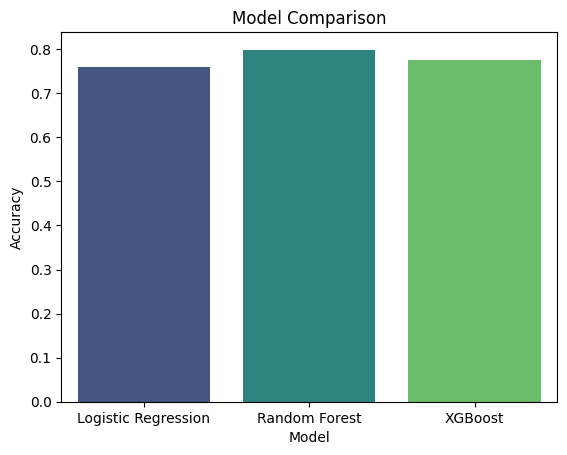

In [72]:
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Comparison")
plt.show()

> # Best Model Selection

In [73]:
best_model = max(results, key=results.get)
print(f"Best Model: {best_model} with Accuracy: {results[best_model]:.4f}")

Best Model: Random Forest with Accuracy: 0.7990
